In [364]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import c_
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

sns.reset_orig()

NOISE = 16
SAMPLES = 2425
SEED = 244825
CLASSES = 2
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
REPEATS = 100

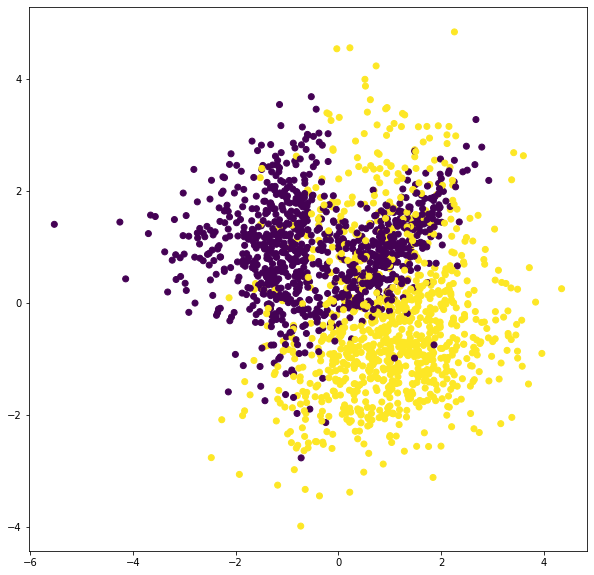

In [365]:
X, y = datasets.make_classification(n_features=3, n_informative=3, random_state=SEED, n_redundant=0, n_samples=SAMPLES, n_classes=2, n_clusters_per_class=3,
                                    class_sep=1, n_repeated=0)

X = X[:, [0, 1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SPLIT, test_size=TEST_SPLIT,
                                                    random_state=SEED)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                     np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10, 10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [366]:

class Relu:
    def __call__(self, x, derivative=False):
            if derivative:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

class Sigmoid:
    def __call__(self, x, derivative=False):
            if derivative:
                return self.__call__(x) * (1 - self.__call__(x))
            else:
                return 1.0 / (1.0 + np.exp(-x))

relu = Relu()
sigmoid = Sigmoid()


In [452]:
class MyNeuralNetwork:
	class Linear:
		def __init__(self, n_inputs, n_neurons):
					super().__init__()
					self.input = None
					self.output = None
					self.weights = np.random.randn(n_inputs, n_neurons)
					self.bias = np.zeros((1, n_neurons))

		def forward(self, X):
			self.input = X
			self.output = (self.input @ self.weights) + self.bias
			return self.output

		def backward(self, error, learning_rate):

			input_error = error @ self.weights.T

			self.weights -= learning_rate * (self.input.T @ error)
			self.bias -= learning_rate * error

			return input_error

	class Activation:
		def __init__(self, activation_function):
					super().__init__()
					self.input = None
					self.output = None
					self.activation_function = activation_function

		def forward(self, X):
			self.input = X
			self.output = self.activation_function(self.input)
			return self.output

		def backward(self, error, learning_rate):
			return self.activation_function(self.input, derivative=True) * error

	def __default_loss(self, predict, target):
		return 2 * (predict - target) / target.size

	def __init__(self, epochs=100, learning_rate=0.01, batch_size=1, loss_function=None):
		self.epochs = epochs
		self.learning_rate = learning_rate
		self.layers = []
		if not loss_function:
			self.loss_function = self.__default_loss
		self.batch_size = batch_size

	def add_layer(self, n_inputs: int, n_neurons: int, activation_function=None):
		self.layers.append(self.Linear(n_inputs, n_neurons))
		self.layers.append(self.Activation(activation_function))

	def fit(self, X, y):

		for e in tqdm(range(self.epochs)):
			for idx in range(len(X)):
				network_output = X[idx].reshape(1, -1)
				for layer in self.layers:
					network_output = layer.forward(network_output)

				error = self.loss_function(network_output, y[idx])

				for layer in reversed(self.layers):
					error = layer.backward(error, learning_rate=self.learning_rate)

	def predict(self, X):
		result = X
		for layer in self.layers:
			result = layer.forward(result)
		return np.where(result > 0.5, 1, 0)

	def predict_proba(self, X):
		result = X
		for layer in self.layers:
			result = layer.forward(result)
		return np.array(result)



In [368]:
test = MyNeuralNetwork(epochs=100, learning_rate=0.1)
test.add_layer(n_inputs=2, n_neurons=100, activation_function=sigmoid)
test.add_layer(n_inputs=100, n_neurons=100, activation_function=sigmoid)
test.add_layer(n_inputs=100, n_neurons=100, activation_function=sigmoid)
test.add_layer(n_inputs=100, n_neurons=1, activation_function=sigmoid)

In [369]:
def tree_function(mdl, X_tr, y_tr, X_te, y_te, xxx=None, yyy=None, silent=False):

    mdl.fit(X_tr, y_tr)

    y_pred = mdl.predict(X_te).flatten()
    # print(y_pred.shape, y_te.shape)

    if silent == False:
        mesh_data = c_[xxx.ravel(), yyy.ravel()]
        Z = np.asarray(mdl.predict(mesh_data)).reshape(xx.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(xx, yy, Z, alpha=0.6, cmap = 'ocean')
        plt.scatter(X_te[:, 0], X_te[:, 1], c=y_te)

        cm_model = confusion_matrix(y_te, y_pred)
        tn_model = cm_model[0][0]
        fn_model = cm_model[0][1]
        tp_model = cm_model[1][1]
        fp_model = cm_model[1][0]
        ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

        fpr, tpr, roc_auc = roc_curve(y_te, y_pred)

        rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
        rok_model.plot()


        print("Czulosc:", tp_model/(tp_model + fn_model))
        print("Swoistosc:", tn_model/(tn_model + fp_model))
        print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

        print("ROC auc:", roc_auc_score(y_test, y_pred))
        print("F1 score:", f1_score(y_test, y_pred))
        print("BA score:", balanced_accuracy_score(y_test, y_pred))

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Czulosc: 0.9063829787234042
Swoistosc: 0.828
Accuracy: 0.865979381443299
ROC auc: 0.8679806905021834
F1 score: 0.8676171079429734
BA score: 0.8679806905021834


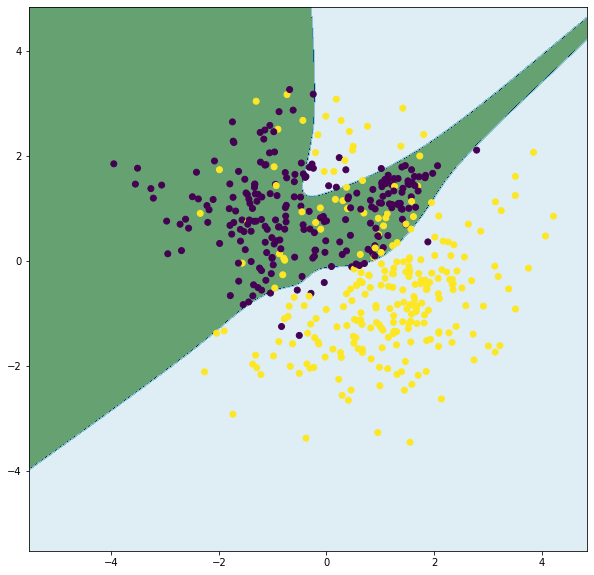

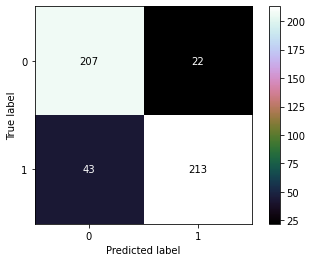

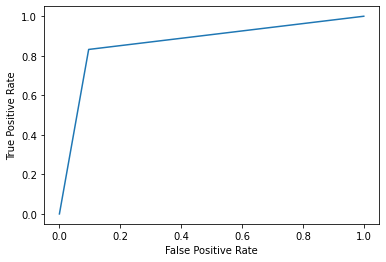

In [370]:
tree_function(test, X_train, y_train, X_test, y_test, xxx=xx, yyy=yy, silent=False)

In [442]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X[:1000].reshape(-1, 1, 28*28)
train_X = train_X / 255.0
test_X = test_X.reshape(-1, 1, 28*28)
test_X = test_X / 255.0

lb = LabelBinarizer()

train_y = lb.fit_transform(train_y[:1000])


In [453]:
test2 = MyNeuralNetwork(epochs=100, learning_rate=0.1)
test2.add_layer(n_inputs=28*28, n_neurons=100, activation_function=sigmoid)
test2.add_layer(n_inputs=100, n_neurons=100, activation_function=sigmoid)
test2.add_layer(n_inputs=100, n_neurons=100, activation_function=sigmoid)
test2.add_layer(n_inputs=100, n_neurons=100, activation_function=sigmoid)
test2.add_layer(n_inputs=100, n_neurons=10, activation_function=sigmoid)

In [426]:
# test2.fit(train_X, train_y)

In [410]:
# pred = test2.predict(test_X)

In [411]:
# pred

array([[[0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]]])

In [423]:
# for row in pred:
# 	print(np.argmax(row))

7
0
0
0
4
0
0
9
4
7
0
2
9
0
0
0
9
7
0
0
9
4
2
0
0
0
7
4
0
0
3
0
0
0
7
2
7
0
5
0
0
0
4
0
0
5
0
0
4
4
6
2
0
0
0
0
4
0
9
4
7
0
0
2
7
9
4
0
3
0
7
0
0
7
0
0
3
0
9
7
7
6
2
7
0
4
7
0
0
0
3
6
9
3
0
6
0
0
6
9
0
0
5
4
0
9
2
0
9
4
0
0
3
9
7
9
9
4
9
0
3
6
7
6
0
9
0
0
0
5
6
6
5
7
0
0
0
0
6
9
6
7
3
0
7
0
9
2
0
0
9
0
0
0
0
0
4
5
2
0
4
0
0
4
4
5
6
0
0
9
4
7
2
2
2
0
0
0
0
0
0
2
9
0
0
9
2
5
0
0
0
0
0
0
0
0
0
6
9
2
3
0
0
0
0
3
9
0
2
0
4
0
0
0
9
0
3
5
0
0
7
2
0
7
0
2
0
4
0
7
0
3
5
7
0
0
0
6
4
0
5
0
0
4
0
0
0
4
4
2
0
0
9
5
7
0
2
0
2
0
0
5
7
7
0
0
0
0
2
0
0
0
0
9
0
4
0
0
2
0
2
9
0
0
7
0
6
4
0
0
4
2
9
2
0
9
0
0
0
3
0
0
0
0
0
2
2
0
4
5
3
0
0
0
0
7
5
5
2
5
0
0
0
0
0
9
2
0
7
0
0
0
0
3
3
0
0
7
0
6
5
7
0
0
2
0
0
0
0
7
0
5
0
6
0
0
5
0
4
9
0
4
0
2
5
0
4
0
6
3
7
2
0
2
0
5
9
0
0
4
0
7
3
7
6
0
0
2
0
0
2
5
6
2
0
5
0
5
4
4
0
0
3
0
0
0
0
0
3
0
7
0
3
7
9
7
0
9
0
5
7
2
9
0
0
0
9
0
6
4
0
2
4
0
9
0
0
0
7
0
0
0
3
0
0
0
0
4
9
0
3
3
2
0
9
0
0
5
0
0
5
4
2
6
7
7
4
0
0
5
0
9
0
0
3
4
0
2
0
3
0
9
7
0
7
0
0
4
0
0
0
5
2
3
7
6
9
0
0
6


In [456]:
def tree_function2(mdl, X_tr, y_tr, X_te, y_te):
	mdl.fit(X_tr, y_tr)

	y_pred2 = mdl.predict_proba(X_te)
	y_pred = []
	for row in y_pred2:
		y_pred.append(np.argmax(row))
	# print(y_pred.shape, y_te.shape)

	cm_model = confusion_matrix(y_te, y_pred)
	tn_model = cm_model[0][0]
	fn_model = cm_model[0][1]
	tp_model = cm_model[1][1]
	fp_model = cm_model[1][0]
	ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

	print("Czulosc:", tp_model / (tp_model + fn_model))
	print("Swoistosc:", tn_model / (tn_model + fp_model))
	print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

	print("F1 score:", f1_score(y_te, y_pred, average='macro'))
	print("BA score:", balanced_accuracy_score(y_te, y_pred))

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Czulosc: 1.0
Swoistosc: 0.9987834549878345
Accuracy: 0.9994728518713759
F1 score: 0.6956620029383753
BA score: 0.6970374892549531


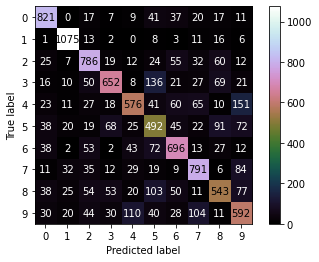

In [457]:
tree_function2(test2, train_X, train_y, test_X, test_y)